In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from kan import KAN
import sympy as sp

In [2]:
def create_point(x:torch.Tensor,y:torch.Tensor):
    return x+x*y #1/np.sqrt(2)*x+x*x/y/8
N=10000
NVAL=100

In [3]:
# random points from 0.1 to 1
xy = torch.rand((N,2))*0.95+0.05
xy2=xy.clone()
xy2[:,1]=-xy2[:,1]
xy = torch.cat((xy,xy2),0)
xdivy = xy[:,:1]/xy[:,1:]
z=create_point(xy[:,:1],xdivy[:,0:])
xyval = torch.rand((NVAL,2))*0.95+0.05
xdivyval = xyval[:,:1]/xyval[:,1:]
zval=create_point(xyval[:,:1],xdivyval[:,:1])

In [4]:
dataset={}
dataset['train_input']=torch.cat((xy[:,:1],xdivy),1)
dataset['train_label']=z
dataset['test_input']=torch.cat((xyval[:,:1],xdivyval),1)
dataset['test_label']=zval

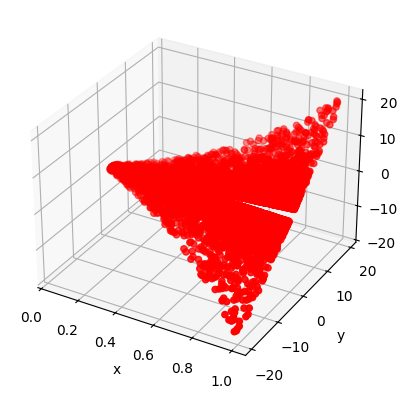

In [5]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Z')
ax.scatter(dataset['train_input'][:,0].cpu().numpy(), dataset['train_input'][:,1].cpu().numpy(), z.cpu().numpy()[:,0], c='r', marker='o')

In [6]:
model = KAN(width=[2,3,1], grid=3, k=5, seed=0)
losses={}
for grid_size in [3,5,10,20]:
    model = KAN(width=[2,3,1], grid=grid_size, k=5, seed=0).initialize_from_another_model(model, dataset['train_input'])
    # train the model
    #model.train(dataset, opt="Adam", steps=10, lr=0.001)
    #model.fix_symbolic(0,0,0,'x^2')
    #model.fix_symbolic(0,1,0,'x')
    losses[grid_size]=model.train(dataset, opt="Adam", steps=5000, lr=0.001,stop_grid_update_step=1000)

train loss: 4.75e-02 | test loss: 2.45e-02 | reg: 1.08e+01 : 100%|█| 5000/5000 [03:34<00:00, 23.28it
train loss: 4.40e-02 | test loss: 4.80e-02 | reg: 9.47e+00 : 100%|█| 5000/5000 [03:49<00:00, 21.77it
train loss: 2.27e-02 | test loss: 2.89e-02 | reg: 8.35e+00 : 100%|█| 5000/5000 [42:40<00:00,  1.95it
train loss: 1.81e-02 | test loss: 5.23e-02 | reg: 8.03e+00 : 100%|█| 5000/5000 [07:26<00:00, 11.20it


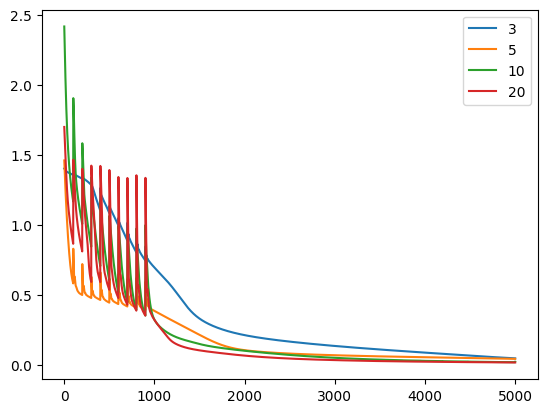

In [7]:
for k,v in losses.items():
    plt.plot(np.array(v['train_loss']), label=str(k))
plt.legend()

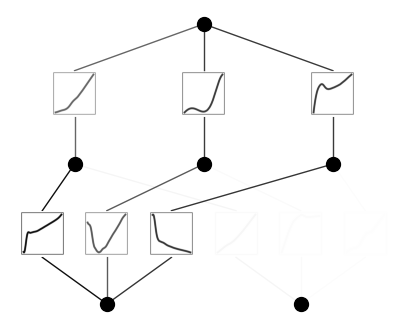

In [8]:
%matplotlib inline
#model.plot()
model.prune()
model.plot(mask=True)

fixing (0,0,0) with x^2, r2=0.905302107334137
fixing (0,0,1) with x^2, r2=0.8868049383163452
fixing (0,0,2) with x^2, r2=0.912497878074646
fixing (0,1,0) with x^2, r2=0.9967413544654846
fixing (0,1,1) with x^2, r2=0.9914337992668152
fixing (0,1,2) with x^2, r2=0.980810284614563
fixing (1,0,0) with x^2, r2=0.9804030656814575
fixing (1,1,0) with x^2, r2=0.8437501788139343
fixing (1,2,0) with x^2, r2=0.6986923217773438


train loss: 4.54e-01 | test loss: 2.09e-01 | reg: 2.58e+01 :  45%|▍| 2250/5000 [03:55<04:47,  9.56it


KeyboardInterrupt: 

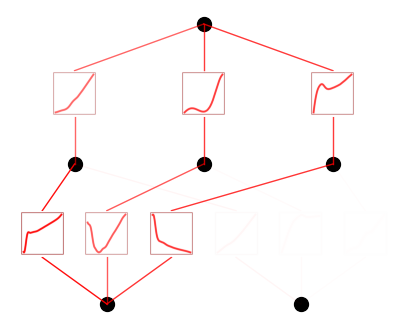

In [9]:
lib = ['x','x^2']
model.auto_symbolic(lib=lib)
# model.fix_symbolic(0,0,0,'sin')

model.prune()
model.plot(mask=True)
loss2=model.train(dataset, opt="Adam", steps=5000, lamb=0.1, lamb_entropy=10.0, lr=0.0001)
model.prune()

In [11]:
model.symbolic_formula()[0][0]

3.76*((0.45 - x_1)**2 + 0.04*(1 - 0.08*x_2)**2 - 0.45)**2 - 7.76*(-0.82*(0.81 - x_1)**2 - 0.7*(-0.06*x_2 - 1)**2 + 1)**2 + 6.83*((1 - 0.8*x_1)**2 - 0.36*(-0.09*x_2 - 1)**2 - 0.26)**2 - 0.39

In [12]:
sympy_expr=sp.sympify(model.symbolic_formula()[0][0])
simplified_expr = sp.simplify(sympy_expr)
expanded=simplified_expr.expand()

In [13]:
expanded_str=expanded.__str__()
expanded_powers=expanded_str.split(' + ')
# replace numbers smaller than 1e-3 with 0
expanded_powers=[p for p in expanded_powers if float(p.split('*')[0])**2>1e-3]
# remove the powers higher than 2
expanded_powers=[p for p in expanded_powers if len(p.split('**'))<2 or int(p.split('**')[-1][0])<3]
expanded_powers=[p for p in expanded_powers if len(p.split('**'))<2 or int(p.split('**')[-1][0])<3]
for i,expanded_power in enumerate(expanded_powers):
    substractions=expanded_power.split(' - ')
    substractions= [s for s in substractions if len(s.split('*'))>1 and float(s.split('*')[0])**2>1e-3]
    expanded_powers[i] = " - ".join(substractions)
expanded_powers=[p for p in expanded_powers if len(p)>0]
expanded_str=' + '.join(expanded_powers)

In [14]:
simplified_expr=sp.sympify(expanded_str)

In [15]:
simplified_expr

1.34*x_1**4 - 3.86*x_1**3 - 0.0555*x_1**2*x_2**2 - 1.68*x_1**2*x_2 + 5.57*x_1**2 + 0.114*x_1*x_2**2 + 3.19*x_1*x_2 - 2.02*x_1

In [ ]:
simplified_expr.subs('x_2', 'x_1/y')

0.284*x_1**3/y - 0.193*x_1**2 + 0.526*x_1**2/y + 0.953*x_1 + 0.233*x_1/y

In [ ]:
expanded

-0.935*x_1**4 - 2.36*x_1**3 - 0.00954*x_1**2*x_2**2 + 0.174*x_1**2*x_2 + 1.14*x_1**2 - 0.012*x_1*x_2**2 + 0.219*x_1*x_2 + 3.31*x_1 - 3.665e-5*x_2**4 - 7.03e-5*x_2**3 + 0.02075*x_2**2 + 0.5461*x_2 - 0.7364